In [45]:
# === Importer ===
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow och Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Sklearn-verktyg
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import class_weight


In [46]:
# === Reproducerbarhet ===
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [47]:
# === Datageneratorer (splitad datasetstruktur) ===
SPLIT_DIR = "brain_tumor_dataset_split"
img_size = 160
bs = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.03,
    height_shift_range=0.03,
    zoom_range=0.3,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, 'train'),
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='binary',
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, 'val'),
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='binary',
    shuffle=False,
    seed=seed
)

# Snabbkontroll
x_batch, y_batch = next(val_generator)
print("Shape på batch:", x_batch.shape)
print("Unika etiketter i batch:", np.unique(y_batch))
print('Train samples:', train_generator.samples)
print('Val samples:', val_generator.samples)
print('Class indices:', train_generator.class_indices)


Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Shape på batch: (32, 160, 160, 3)
Unika etiketter i batch: [0. 1.]
Train samples: 202
Val samples: 51
Class indices: {'no': 0, 'yes': 1}
Shape på batch: (32, 160, 160, 3)
Unika etiketter i batch: [0. 1.]
Train samples: 202
Val samples: 51
Class indices: {'no': 0, 'yes': 1}


In [48]:
# === Läckagekontroll: kontrollera överlapp och klassfördelning mellan train/val ===
import numpy as np

def _get_filepaths(gen):
    # DirectoryIterator kan ha .filepaths eller .filenames beroende på TF-version
    return getattr(gen, 'filepaths', None) or getattr(gen, 'filenames', None) or []

train_paths = _get_filepaths(train_generator)
val_paths = _get_filepaths(val_generator)

print('Train samples:', getattr(train_generator, 'samples', len(train_paths)))
print('Val samples:  ', getattr(val_generator, 'samples', len(val_paths)))
print('Train generator shuffle:', getattr(train_generator, 'shuffle', None))
print('Val generator shuffle:  ', getattr(val_generator, 'shuffle', None))
print('Class indices:', train_generator.class_indices)

# Kontrollera överlappning i filvägar
train_set = set(train_paths)
val_set = set(val_paths)
overlap = train_set.intersection(val_set)
print('Antal gemensamma filer mellan train/val:', len(overlap))
if len(overlap) > 0:
    print('Exempel på gemensamma filer (upp till 10):')
    for p in list(overlap)[:10]:
        print(' ', p)

# Jämför klassfördelningar om attributen finns
try:
    print('\nTrain class counts:', dict(zip(*np.unique(train_generator.classes, return_counts=True))))
    print('Val class counts:  ', dict(zip(*np.unique(val_generator.classes, return_counts=True))))
except Exception as e:
    print('Kunde inte hämta klassfördelningar från generatorerna:', e)

# Tips: om overlap > 0 skapa en explicit fil-split (t.ex. sklearn.model_selection.train_test_split)
# eller använd separata mappar för train/val utan validation_split i ImageDataGenerator.


Train samples: 202
Val samples:   51
Train generator shuffle: True
Val generator shuffle:   False
Class indices: {'no': 0, 'yes': 1}
Antal gemensamma filer mellan train/val: 0

Train class counts: {0: 78, 1: 124}
Val class counts:   {0: 20, 1: 31}


**Splitten skapades redan**: den stratifierade train/val-splitten har körts och filer kopierats till `brain_tumor_dataset_split/train` och `.../val`.
Du behöver inte köra data-kopieringscellen igen (den är borttagen för att undvika att duplicera filer).

In [49]:
# === Klassvikter ===
classes = train_generator.classes
unique, counts = np.unique(classes, return_counts=True)
print("train counts:", dict(zip(unique, counts)))

class_weights = None
if len(unique) == 2:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=unique,
        y=classes
    )
    class_weights = {int(k): float(v) for k, v in zip(unique, weights)}
    print("class_weights:", class_weights)



train counts: {0: 78, 1: 124}
class_weights: {0: 1.294871794871795, 1: 0.8145161290322581}


In [50]:
base = EfficientNetB0(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # fryser baslagren

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=out)

In [51]:
# === Finjustering ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

base.trainable = True  # lås upp hela basen, men vi fryser de första lagren nedan
for layer in base.layers[:30]:  
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

early = EarlyStopping(patience=5, restore_best_weights=True)
reduce = ReduceLROnPlateau(factor=0.3, patience=2)


history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early, reduce],
    verbose=1
)

c:\Users\Test\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5794 - auc: 0.5315 - loss: 0.7082 - precision: 0.6802 - recall: 0.6535 - val_accuracy: 0.5686 - val_auc: 0.5016 - val_loss: 0.6815 - val_precision: 0.6098 - val_recall: 0.8065 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5794 - auc: 0.5315 - loss: 0.7082 - precision: 0.6802 - recall: 0.6535 - val_accuracy: 0.5686 - val_auc: 0.5016 - val_loss: 0.6815 - val_precision: 0.6098 - val_recall: 0.8065 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6013 - auc: 0.6770 - loss: 0.6211 - precision: 0.7336 - recall: 0.6215 - val_accuracy: 0.5882 - val_auc: 0.6323 - val_loss: 0.6539 - val_precision: 0.7083 - val_recall: 0.5484 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6013 - auc: 0.6770 - loss: 0.6211 - precision: 0.7336 - recall: 0.6215 - val_accuracy: 0.5882 - val_auc: 0.6323 - val_loss: 0.6539 - val_pre

Bästa tröskel: 0.47
F1-score: 0.952, Precision: 0.938, Recall: 0.968


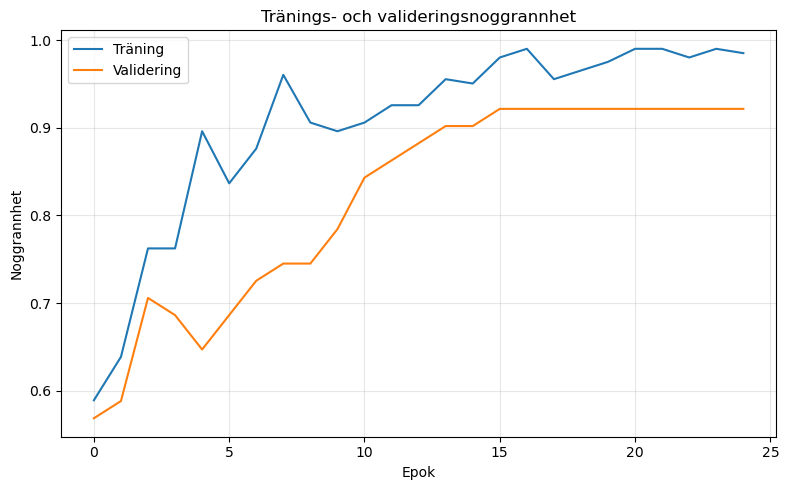

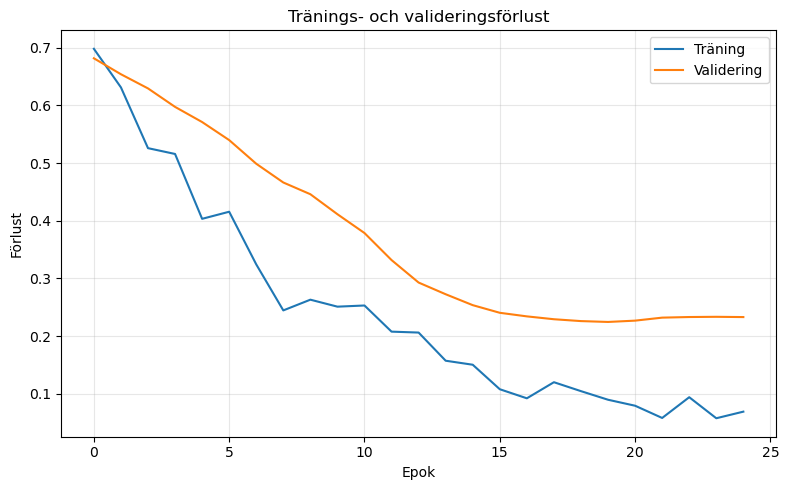


Klassificeringsrapport:
              precision    recall  f1-score   support

          no       0.95      0.90      0.92        20
         yes       0.94      0.97      0.95        31

    accuracy                           0.94        51
   macro avg       0.94      0.93      0.94        51
weighted avg       0.94      0.94      0.94        51



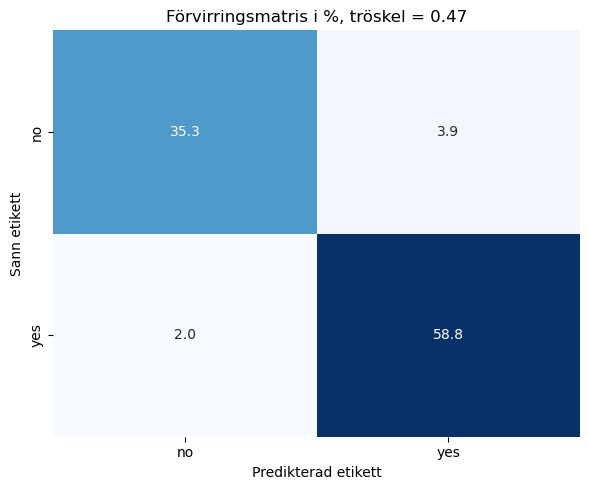

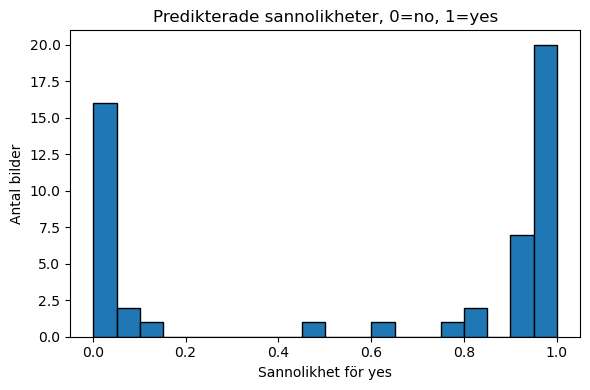

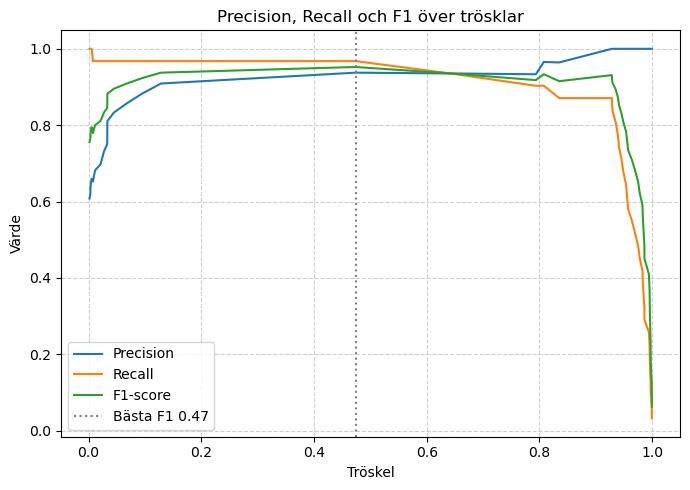


--- Resultatsammanfattning ---
Modellen tränades med EfficientNetB0 och finjustering av de sista lagren.
Bästa tröskel enligt F1: 0.47
F1: 0.95, Precision: 0.94, Recall: 0.97


In [ ]:
# === Utvärdering ===

# Prediktioner och sanningsdata
val_generator.reset()
probs = model.predict(val_generator, verbose=0).ravel()
y_true = val_generator.classes

# Precision, recall och F1 per tröskel
prec, rec, thr = precision_recall_curve(y_true, probs)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.nanargmax(f1)
best_thr = 0.5 if best_idx >= len(thr) else float(thr[best_idx])

# Sammanfattning av bästa tröskel
best_f1 = f1[best_idx]
best_prec = prec[best_idx]
best_rec = rec[best_idx]
print(f"Bästa tröskel: {best_thr:.2f}")
print(f"F1-score: {best_f1:.3f}, Precision: {best_prec:.3f}, Recall: {best_rec:.3f}")

# Träningshistorik
plt.figure(figsize=(8, 5))
plt.plot(history_ft.history['accuracy'], label='Träning')
plt.plot(history_ft.history['val_accuracy'], label='Validering')
plt.title('Tränings- och valideringsnoggrannhet')
plt.xlabel('Epok')
plt.ylabel('Noggrannhet')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history_ft.history['loss'], label='Träning')
plt.plot(history_ft.history['val_loss'], label='Validering')
plt.title('Tränings- och valideringsförlust')
plt.xlabel('Epok')
plt.ylabel('Förlust')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Klassificeringsrapport
threshold = best_thr
y_pred = (probs >= threshold).astype(int)
print("\nKlassificeringsrapport (Valideringsdata):")
print(classification_report(y_true, y_pred, target_names=['no', 'yes']))

# Förvirringsmatris (procent)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predikterad etikett')
plt.ylabel('Sann etikett')
plt.title(f'Förvirringsmatris i %, tröskel = {threshold:.2f}')
plt.tight_layout()
plt.show()

# Sannolikhetsfördelning
plt.figure(figsize=(6, 4))
plt.hist(probs, bins=20, edgecolor='black')
plt.title("Predikterade sannolikheter, 0=no, 1=yes")
plt.xlabel("Sannolikhet för yes")
plt.ylabel("Antal bilder")
plt.tight_layout()
plt.show()

# Precision, Recall och F1 över trösklar
plt.figure(figsize=(7, 5))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1], label='Recall')
plt.plot(thr, f1[:-1], label='F1-score')
plt.axvline(x=best_thr, linestyle=':', color='gray', label=f'Bästa F1 {best_thr:.2f}')
plt.xlabel("Tröskel")
plt.ylabel("Värde")
plt.title("Precision, Recall och F1 över trösklar")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Kort resultatöversikt
print("\n--- Resultatsammanfattning ---")
print(f"Modellen tränades med EfficientNetB0 och finjustering av de sista lagren.")
print(f"Bästa tröskel enligt F1: {best_thr:.2f}")
print(f"F1: {best_f1:.2f}, Precision: {best_prec:.2f}, Recall: {best_rec:.2f}")
